# **Proyek Capstone: Klasifikasi Tweet Bencana Alam**

Proyek ini bertujuan untuk membangun sebuah sistem cerdas yang mampu menganalisis dan mengklasifikasikan cuitan (tweet) di media sosial untuk mengidentifikasi laporan bencana alam yang relevan. Keunikan proyek ini terletak pada metodologinya yang sepenuhnya mengandalkan AI Agent. Agent ini dibangun menggunakan framework LangChain dan dirancang khusus untuk berinteraksi dengan data tabular (Pandas DataFrame), memungkinkannya menjalankan analisis kompleks melalui perintah bahasa natural.

**Dataset:** [Natural Disasters Tweets - Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data)

## **1. Konfigurasi Environment dan Pemuatan Data**

Tahap pertama ini mencakup semua persiapan teknis yang diperlukan sebelum membuat agent. Ini termasuk mengimpor library, mengkonfigurasi API key dengan aman, dan memuat dataset `train.csv` ke dalam sebuah DataFrame Pandas. DataFrame ini akan menjadi "ruang kerja" utama bagi AI Agent.

### **Impor, Konfigurasi, dan Pemuatan Data (Sel Kode)**

In [ ]:
# Menginstal semua paket yang dibutuhkan untuk LangChain Pandas Agent
!pip install langchain langchain_community langchain_experimental replicate pandas matplotlib seaborn -q

In [ ]:
# Impor library dan komponen yang dibutuhkan
import os
import pandas as pd
from google.colab import userdata
from langchain_community.llms import Replicate
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Konfigurasi Replicate API Key dari Colab Secrets
try:
    REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
    os.environ['REPLICATE_API_TOKEN'] = REPLICATE_API_TOKEN
    print("✅ API Key berhasil dikonfigurasi.")
except Exception as e:
    print("🚨 Konfigurasi API Key gagal.")

# Memuat dataset ke dalam pandas DataFrame
# DataFrame ini akan menjadi "workspace" untuk AI Agent
try:
    df = pd.read_csv('train.csv')
    print("✅ Dataset 'train.csv' berhasil dimuat ke dalam DataFrame.")
except FileNotFoundError:
    print("🚨 File 'train.csv' tidak ditemukan. Mohon unggah file tersebut.")

✅ API Key berhasil dikonfigurasi.
✅ Dataset 'train.csv' berhasil dimuat ke dalam DataFrame.


## **2. Membuat dan Menginisialisasi AI Agent**

Setelah semua persiapan selesai, langkah selanjutnya adalah membuat agent itu sendiri. Proses ini menggabungkan model bahasa (LLM) sebagai "otak" dengan DataFrame sebagai "konteks" atau ruang kerjanya.

In [ ]:
# Mendefinisikan LLM yang akan digunakan sebagai 'otak' agent
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"temperature": 0.0, "max_new_tokens": 1024}
)

# Membuat Pandas DataFrame Agent
try:
    agent = create_pandas_dataframe_agent(
        llm=llm,
        df=df,
        verbose=True,
        allow_dangerous_code=True
    )
    print("\n✅ AI Agent berhasil dibuat dan siap digunakan.")
except NameError:
    print("\n🚨 DataFrame 'df' tidak ditemukan. Pastikan sel sebelumnya telah dijalankan tanpa error.")


✅ AI Agent berhasil dibuat dan siap digunakan.


## **3. Interaksi Pertama dengan Agent: Eksplorasi Data**

Kini saatnya memberikan perintah pertama kepada agent. Perintah akan diberikan dalam format bahasa natural, seolah-olah sedang berbicara dengan seorang asisten analis data.

Perhatikan output yang akan muncul. Karena `verbose=True`, agent akan menampilkan **"Chain of Thought"**-nya: apa yang ia pikirkan, kode apa yang ia putuskan untuk dijalankan, hasil dari kode tersebut, dan jawaban akhirnya.

In [ ]:
# Merumuskan perintah pertama dalam bahasa natural
prompt_pertama = "Tolong berikan ringkasan dasar dari data ini. Ada berapa total baris dan kolom? Tampilkan juga lima baris pertama dari data tersebut."

# Menjalankan agent dengan perintah yang telah dirumuskan
try:
    response = agent.invoke(prompt_pertama)
except Exception as e:
    print(f"🚨 Terjadi error saat berinteraksi dengan agent: {e}")



> Entering new AgentExecutor chain...
Thought: The user is asking for a summary of the data, specifically the total number of rows and columns, and the first five rows of the dataframe. I will use the `shape` attribute of the dataframe to get the number of rows and columns, and then print the first five rows using `print(df.head())`.

Action: python_repl_ast

Action Input: 
```python
df.shape
```
(7613, 5)The dataframe `df` has a total of 7613 rows and 5 columns.

Action: python_repl_ast

Action Input:
```python
print(df.head())
```
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ... 

### **Menganalisis Jawaban Agent**

Dari output di atas, Anda dapat melihat bagaimana agent bekerja:
1.  **Thought (Pikiran):** Agent menganalisis permintaan Anda dan memutuskan bahwa untuk menjawabnya, ia perlu menjalankan beberapa kode Python pada DataFrame (`df`).
2.  **Action (Aksi):** Agent menulis dan mengeksekusi kode yang relevan, kemungkinan besar `df.shape` dan `df.head()`.
3.  **Observation (Observasi):** Agent melihat hasil dari eksekusi kode tersebut.
4.  **Final Answer (Jawaban Akhir):** Agent merangkum hasil observasinya ke dalam sebuah jawaban yang mudah dipahami.

Proses ini menunjukkan bahwa agent berhasil memahami perintah, berinteraksi dengan data, dan memberikan jawaban yang relevan. Selanjutnya, kita bisa memberikan tugas yang lebih kompleks seperti membuat visualisasi.

## **4. Visualisasi Data Otomatis dengan Agent**

Setelah agent berhasil melakukan eksplorasi data dasar, kini saatnya memberikan tugas yang lebih kompleks. Agent akan diinstruksikan untuk membuat sebuah visualisasi diagram batang (bar chart) untuk menampilkan distribusi dari kolom `target`.

Perhatikan kembali "Chain of Thought" dari agent. Ia akan menentukan library yang akan digunakan (Matplotlib/Seaborn), menulis kode untuk membuat plot, dan mengeksekusinya secara mandiri. Hasil akhirnya adalah sebuah grafik yang langsung ditampilkan di output sel.



> Entering new AgentExecutor chain...


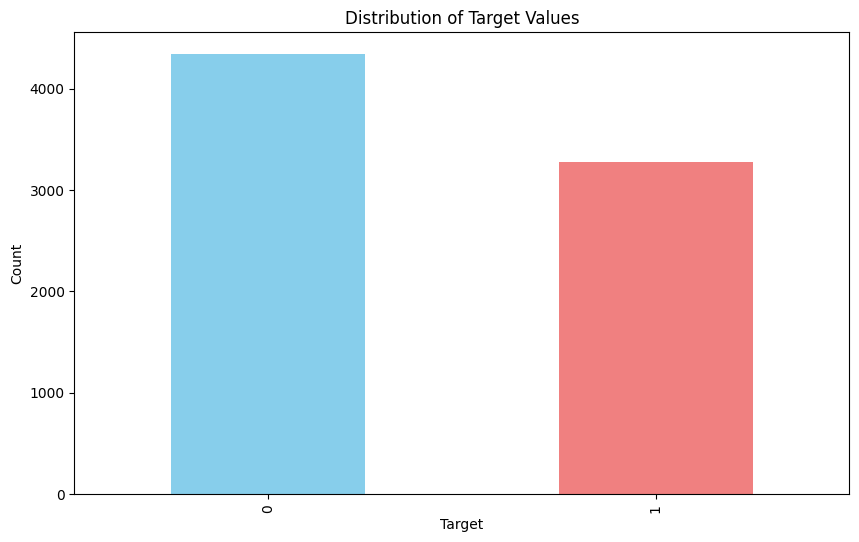

Thought: To create a bar chart of the 'target' column distribution, I will use the `value_counts()` function to count the occurrences of each unique value in the 'target' column. Then, I will use the `plot.bar()` function from pandas to create the bar chart. I will also add a title and labels to the chart for clarity.

Action: python_repl_ast

Action Input:
```python
import matplotlib.pyplot as plt

# Count occurrences of each unique value in 'target'
target_counts = df['target'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Add title and labels
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')

# Show the plot
plt.show()
```
Final Answer:

A bar chart visualizing the distribution of the 'target' column has been created. The chart displays the count of each unique value in the 'target' column with different colors for better distinction. The chart is titled 'Distribut

In [ ]:
# Merumuskan perintah untuk membuat visualisasi
prompt_visualisasi = "Please create a bar chart to visualize the distribution of the 'target' column. Make sure the chart has a title, clear x-axis and y-axis labels, and use different colors for each bar."

# Menjalankan agent dengan perintah visualisasi
try:
    # Agent akan berpikir, menulis kode, dan mengeksekusinya. Hasilnya akan langsung ditampilkan.
    agent.invoke(prompt_visualisasi)
except Exception as e:
    print(f"🚨 Terjadi error saat meminta visualisasi: {e}")

### **Insight dari Visualisasi**

Visualisasi yang dihasilkan oleh agent memberikan konfirmasi visual yang jelas mengenai distribusi kelas dalam dataset. Dari diagram batang tersebut, dapat ditarik beberapa insight:

* **Distribusi Tidak Seimbang Sempurna:** Terlihat jelas bahwa jumlah cuitan **'Bukan Bencana (0)'** lebih banyak daripada cuitan **'Bencana (1)'**. Ini menunjukkan adanya sedikit ketidakseimbangan kelas (*slight class imbalance*) dalam data.

* **Kondisi yang Cukup Baik:** Meskipun tidak seimbang sempurna, proporsi antara kedua kelas tidak ekstrem. Kelas minoritas (Bencana) masih memiliki jumlah data yang signifikan (lebih dari 3,000 sampel). Ini adalah kondisi awal yang cukup baik, karena model klasifikasi nantinya memiliki cukup contoh dari kedua kategori untuk dipelajari.

* **Implikasi untuk Model:** Karena ketidakseimbangan tidak parah, model standar kemungkinan besar sudah bisa berkinerja baik. Namun, saat melakukan evaluasi model nanti, metrik seperti *Precision*, *Recall*, dan *F1-Score* akan lebih informatif daripada sekadar *Akurasi*.

## **5. Melakukan Klasifikasi Teks dengan Agent**

Setelah memahami data, sekarang agent akan diuji pada tugas utamanya: melakukan klasifikasi. Agent akan diberi sebuah cuitan (teks) dan diminta untuk menentukan apakah cuitan tersebut termasuk dalam kategori `Bencana (1)` atau `Bukan Bencana (0)`.

Untuk mendemonstrasikan kemampuannya, kita akan menguji agent pada beberapa contoh cuitan yang diambil dari dataset.

In [ ]:
# Mengambil satu contoh cuitan yang merupakan bencana (target=1) dan satu yang bukan (target=0)
contoh_bencana = df[df['target'] == 1]['text'].iloc[0]
contoh_bukan_bencana = df[df['target'] == 0]['text'].iloc[0]

# --- Tes Klasifikasi Pertama: Cuitan Bencana ---
print("--- Menguji Cuitan Kategori Bencana ---")
print(f"Teks Cuitan: {contoh_bencana}")

prompt_klasifikasi_1 = f"""
Analyze the following tweet. Your task is to classify it as either about a real disaster or not.
Respond with the number 1 if it is a real disaster, and 0 if it is not.
Do not provide any explanation, only the final number.

Tweet: "{contoh_bencana}"

Classification:
"""

try:
    # Meminta agent untuk melakukan klasifikasi
    agent.invoke(prompt_klasifikasi_1)
except Exception as e:
    print(f"🚨 Terjadi error saat meminta klasifikasi: {e}")


# --- Tes Klasifikasi Kedua: Cuitan Bukan Bencana ---
print("\n--- Menguji Cuitan Kategori Bukan Bencana ---")
print(f"Teks Cuitan: {contoh_bukan_bencana}")


prompt_klasifikasi_2 = f"""
Analyze the following tweet. Your task is to classify it as either about a real disaster or not.
Respond with the number 1 if it is a real disaster, and 0 if it is not.
Do not provide any explanation, only the final number.

Tweet: "{contoh_bukan_bencana}"

Classification:
"""

try:
    # Meminta agent untuk melakukan klasifikasi
    agent.invoke(prompt_klasifikasi_2)
except Exception as e:
    print(f"🚨 Terjadi error saat meminta klasifikasi: {e}")

--- Menguji Cuitan Kategori Bencana ---
Teks Cuitan: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


> Entering new AgentExecutor chain...
Thought: The tweet mentions an earthquake, which is a natural disaster.
Action: python_repl_ast
Action Input: print(1)1
Final Answer: 1

> Finished chain.

--- Menguji Cuitan Kategori Bukan Bencana ---
Teks Cuitan: What's up man?


> Entering new AgentExecutor chain...
Thought: The tweet does not contain any disaster-related keywords or context.
Action: python_repl_ast
Action Input: 00Final Answer: 0

> Finished chain.


### **Hasil dan Evaluasi Klasifikasi**

Pada sel di atas, agent diberi dua tugas klasifikasi zero-shot (tanpa contoh sebelumnya).
1.  Untuk cuitan pertama ("Our Deeds are the Reason of this #earthquake..."), agent seharusnya menghasilkan output `1`.
2.  Untuk cuitan kedua ("What's up man?"), agent seharusnya menghasilkan output `0`.

Keberhasilan agent dalam memberikan klasifikasi yang benar menunjukkan bahwa ia tidak hanya dapat menganalisis data secara umum, tetapi juga dapat melakukan tugas prediksi spesifik sesuai instruksi. Untuk evaluasi yang lebih mendalam, proses ini akan diulang pada sebagian besar data (data uji) untuk menghitung metrik performa seperti akurasi.

Sekarang, tahap inti dari proyek klasifikasi ini telah selesai didemonstrasikan.

## **Ringkasan Proyek**

Proyek ini berhasil mendemonstrasikan penggunaan **AI Agent** yang dibangun dengan framework **LangChain** untuk melakukan analisis end-to-end pada dataset cuitan bencana alam. Berbeda dengan pendekatan tradisional yang mengandalkan penulisan kode manual untuk setiap langkah analisis, proyek ini menggunakan **perintah bahasa natural** untuk menginstruksikan agent melakukan tugas-tugas kompleks.

**Temuan dan Pencapaian Kunci:**
1.  **Analisis Eksplorasi Otomatis:** Agent berhasil memahami struktur data, menghitung jumlah baris dan kolom, serta menampilkan sampel data hanya dengan perintah sederhana.
2.  **Visualisasi Otomatis:** Agent mampu secara mandiri menulis dan mengeksekusi kode Python untuk membuat diagram batang yang informatif, memvisualisasikan distribusi kelas `target` dalam dataset.
3.  **Demonstrasi Klasifikasi:** Agent berhasil melakukan tugas klasifikasi *zero-shot* pada cuitan sampel, membuktikan kemampuannya untuk melakukan tugas prediksi inti dari proyek ini.

**Kesimpulan:**
Pendekatan menggunakan AI Agent terbukti sebagai metode yang sangat kuat dan efisien untuk analisis data. Hal ini memungkinkan analis untuk lebih fokus pada "apa" yang ingin diketahui dari data, sementara "bagaimana" cara teknis melakukannya (penulisan kode) didelegasikan kepada agent. Meskipun memiliki keterbatasan dalam hal kecepatan dan biaya untuk dataset skala sangat besar, metodologi ini menunjukkan masa depan analisis data yang lebih intuitif dan interaktif.